In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [42]:
# Load csv file
df = pd.read_csv('/content/drive/MyDrive/Amazon_Unlocked_Mobile.csv', encoding='utf-8')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [43]:
df.shape

(413840, 6)

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
df = df.sample(frac=0.1, random_state=0) #SINCE DATA IS LARGER...CONSIDERING SMALL PART OF DATA FOR TRIANING

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

#FINALLY TRYING MAKE REVIEWS INTO 2CLASSES...EITHER GOOD REVIEW(1) OR BAD REVIEW(0)  

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,5,"For the price I paid for this devices, its fan...",0.0,1
123493,Blu LIFE 8 Unlocked (Pink),BLU,199.98,5,love love love it....good buy...recommend to a...,0.0,1
335592,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,4,Good,0.0,1
246353,"Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...",Motorola,82.00,1,Not good. Returned first phone and they sent m...,0.0,0
273324,Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...,Nokia,149.35,4,Met expectations! I'm very satisfied!Even arri...,1.0,1


In [46]:
df.shape

(30888, 7)

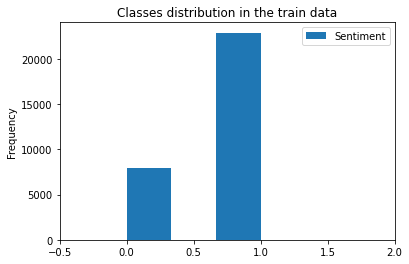

In [47]:
#to check balance between positie and negative reviews

df["Sentiment"].plot.hist(bins=3)
plt.title('Classes distribution in the train data')
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

SINCE IT IS UNBALANCED DATASET...WE ARE USING DATASAMPLING TECHNIQUE CALLED SMOTE

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV

##### Review is good or bad decided based on rating ... here it is SENTIMENT classification

In [49]:
# Split data into training set and validation with same ratio of classes in data  
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], test_size=0.1,stratify=df['Sentiment'], random_state=42)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 27799 training examples and 3089 validation examples. 

Show a review in the training set : 
 Very good


## TEXT PREPROCESSING

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
* remove html tags using BeautifulSoup
* remove non-character such as digits and symbols
* convert to lower case
* remove stop words such as "the" and "and" if needed
* convert to root words by stemming if needed

In [50]:
from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer

In [51]:
pip install lxml


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
## FUNCTION TO REMOVE STOP WORDS AND DO STEMMING

def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    
    text = BeautifulSoup(raw_text, 'lxml').get_text()         # remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)             # remove non-character
    words = letters_only.lower().split()                      # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [53]:
# APPENDING THE CLEANED DATA INTO AN EMPTY LIST
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 very good


In [54]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score


In [55]:
## FUNCTION FOR METRICS

def modelEvaluation(predictions):
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

##### TFIDF VECTORIZER WITH LOGISTIC REGRESSION AS CLASSIFIER

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [57]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])



Number of features : 5973 

Show some feature names : 
 ['00', 'challenge', 'factory', 'letdown', 'primarily', 'states']


In [92]:
import imblearn

In [60]:
#USING SMOTE TO TACKLE CLASS IMBALANCE

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_tfidf, y_train)

In [ ]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_res, y_res)

In [62]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'return' 'waste' 'disappointed' 'stopped' 'horrible' 'poor' 'worst'
 'slow' 'returning']

Top 10 features with largest coefficients : 
['love' 'great' 'excellent' 'perfect' 'good' 'best' 'excelente' 'awesome'
 'easy' 'amazing']


In [64]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9155

AUC score : 0.9153

Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       798
           1       0.97      0.92      0.94      2291

    accuracy                           0.92      3089
   macro avg       0.88      0.92      0.89      3089
weighted avg       0.92      0.92      0.92      3089


Confusion Matrix : 
 [[ 730   68]
 [ 193 2098]]


#### USING TOKENISER AND LSTM

In [ ]:
from nltk import sent_tokenize, word_tokenize, pos_tag
from keras_preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM

In [ ]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 10


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq =pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical((y_train).astype('float32'), nb_classes)
y_test_seq = np_utils.to_categorical((y_test).astype('float32'), nb_classes)
print('X_train shape:', X_train_seq.shape) 
print('X_test shape:', X_test_seq.shape) 
print('y_train shape:', y_train_seq.shape)
print('y_test shape:', y_test_seq.shape) 

X_train shape: (27799, 100)
X_test shape: (3089, 100)
y_train shape: (27799, 2)
y_test shape: (3089, 2)


In [ ]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(LSTM(128)) 
model1.add(Dropout(0.2))
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, epochs=nb_epoch,batch_size=batch_size,verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Epoch 1/10
869/869 [==============================] - 145s 164ms/step - loss: 0.2583 - accuracy: 0.8967
Epoch 2/10
869/869 [==============================] - 124s 143ms/step - loss: 0.1395 - accuracy: 0.9511
Epoch 3/10
869/869 [==============================] - 120s 138ms/step - loss: 0.0999 - accuracy: 0.9663
Epoch 4/10
869/869 [==============================] - 120s 138ms/step - loss: 0.0765 - accuracy: 0.9754
Epoch 5/10
869/869 [==============================] - 150s 172ms/step - loss: 0.0598 - accuracy: 0.9811
Epoch 6/10
869/869 [==============================] - 181s 208ms/step - loss: 0.0571 - accuracy: 0.9810
Epoch 7/10
869/869 [==============================] - 178s 205ms/step - loss: 0.0401 - accuracy: 0.9872
Epoch 8/10
869/869 [==============================] - 172s 198ms/step - loss: 0.0335 - accuracy: 0.9899
Epoch 9/10
869/869 [==============================] - 165s 190ms/step - loss: 0.0248 - accuracy: 0.9931
Epoch 10/10
97/97 [==============================] - 5s 40ms/ste